In [116]:
from roofline_utils import *

### Read in the scraped source codes

### Open the Gathered Data CSV Files

In [117]:

# we need to gather more data for this dataset
df = pd.read_csv('../roofline-data-new.csv', quotechar='"', dtype=dtypes)

# if we're loading old data that didn't gather intops
#df = pd.read_csv('../roofline-data-OLD-only-cuda.csv', quotechar='"', dtype=dtypes)
#df['intops'] = 0
#df['intPerf'] = 0
#df['intAI'] = 0

df['language'] = df['targetName'].apply(lambda x: 'CUDA' if '-cuda' in x else 'OMP')

print(df.shape)


(2970, 17)


In [118]:
# because a lot of these kernels were sampled twice, let's drop the first sample (which typically runs for longer than the second sample)
#grouped = df.groupby(by=['Kernel Name', 'kernelName', 'targetName', 'exeArgs'])['xtime'].min().reset_index()
grouped = df.groupby(by=['Kernel Name', 'targetName', 'exeArgs'])['xtime'].min().reset_index()

print(grouped.head())
print(grouped.shape)

df = df.merge(grouped, on=list(grouped.columns), how='inner')
# it turns out when we give REGEX to 'ncu' to capture kernels, some kernel names have
# extra characters that also get captured. e.g: AIDW_Kernel and AIDW_Kernel_Tiled both match for the former
# so to deal with this we mainly filter by the 'Kernel Name'  instead of 'kernelName'
#df = df.drop_duplicates(subset=['Kernel Name', 'kernelName', 'targetName', 'exeArgs', 'language'])

counts = df.groupby(['language']).count()
print(counts)
print(df.shape)

                                         Kernel Name           targetName  \
0  AESEncrypt(uchar4 *, const uchar4 *, const uch...             aes-cuda   
1  AIDW_Kernel(const float *, const float *, cons...            aidw-cuda   
2  AIDW_Kernel_Tiled(const float *, const float *...            aidw-cuda   
3  BP_queens_root_dfs(int, unsigned int, int, con...          nqueen-cuda   
4  BezierGPU(const XYZ *, XYZ *, int, int, int, int)  bezier-surface-cuda   

                                             exeArgs        xtime  
0                  100 0 ../urng-sycl/URNG_Input.bmp     549600.0  
1                                           10 1 100    3713056.0  
2                                           10 1 100    2815680.0  
3                                           15 7 100  154966912.0  
4  ../face-cuda/Face.pgm ../face-cuda/info.txt .....    4395488.0  
(1306, 4)
          Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  xtime  Block Size  \
language                              

### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [119]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

print(df.columns)

(1378, 17)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language'],
      dtype='object')


### DROP rows that don't have scraped source code -- the rest of the viz data is on this subset

Search the scraped kernels for their source code -- quantify their token count and add it to the dataframe

In [120]:

enc = tiktoken.encoding_for_model("gpt-4o-mini")

In [121]:
df['numTokens'] = -1
df['kernelCode'] = ''

df = df.reset_index(drop=True)

toDrop = []

# for each sample we got
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    targetName = row['targetName']
    kernelName = row['Kernel Name']
    exeArgs = row['exeArgs']
    language = row['language']
    device = row['device']

    kernelCode = ''
    for elem in scrapedCodes:
        basename = elem['basename']
        if basename == targetName:
            # since all the codes are the same for a target, we grab the first element
            kernelCode = list(elem['kernels'].values())[0]
            encoded = enc.encode(kernelCode)
            df.iloc[index, df.columns.get_loc('numTokens')] = len(encoded)
            df.iloc[index, df.columns.get_loc('kernelCode')] = kernelCode
            break

    # if a target's kernel code couldn't be found, it's because it's source has too
    # many token, and we had dropped it. Thus, we need to drop the code from our 
    # dataframe
    if kernelCode == '':
        #print(f'Dropping {targetName} -- [{kernelName}]')
        toDrop.append(index)


print(f'Will be dropping {len(toDrop)} rows from the DF -- as we dropped their scraped code for having too many tokens')
print()

print(df.columns)

100%|██████████| 1378/1378 [00:01<00:00, 988.03it/s] 

Will be dropping 451 rows from the DF -- as we dropped their scraped code for having too many tokens

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode'],
      dtype='object')


In [122]:
df = df.drop(index=toDrop, axis=1)

In [123]:
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.head())
print(df.tail())

(927, 19)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language               object
numTokens               int64
kernelCode             object
dtype: object
                                         Kernel Name       traffic      dpAI  \
0  haccmk_kernel(int, int, const float *, const f...  7.156

### Check some high-level stats

In [124]:
# how many different kernel invocations did we capture?

totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 433
Total unique kernel executions recorded: 884
Number of kernels with no arithmetic intensity (AI) 388 (43.89%)
Number of non-zero AI single-precision kernels recorded: 453 (51.24%)
Number of non-zero AI double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf single-precision kernels recorded: 453 (51.24%)
Number of non-zero Perf double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf intop kernels recorded: 884 (100.0%)
Number of non-zero AI intop kernels recorded: 884 (100.0%)


In [125]:

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [126]:
# scale everything to be in TFLOP/s
df['dpPerf'] = df['dpPerf']*(1e-12)
df['spPerf'] = df['spPerf']*(1e-12)
df['intPerf'] = df['intPerf']*(1e-12)


### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

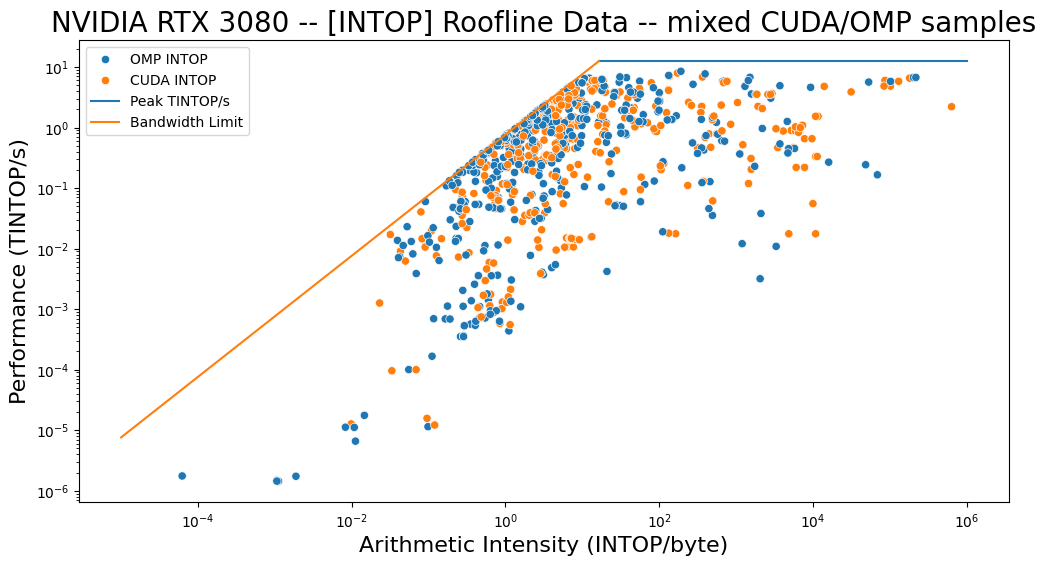

In [127]:
# it should be noted that samples with AI=0 and Perf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', hue='language', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)

# plot the intOPS roofline line
ax.plot([intOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e6], [intOPMaxPerfTFLOP,intOPMaxPerfTFLOP], label='Peak SP TFLOP/s')

# plot the roofline slanted line
ax.plot([1e-5, intOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,intOPMaxPerfTFLOP], label='Max Bandwidth')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(f'{gpuName} -- [INTOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TINTOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = ['OMP INTOP', 'CUDA INTOP', 'Peak TINTOP/s', 'Bandwidth Limit']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

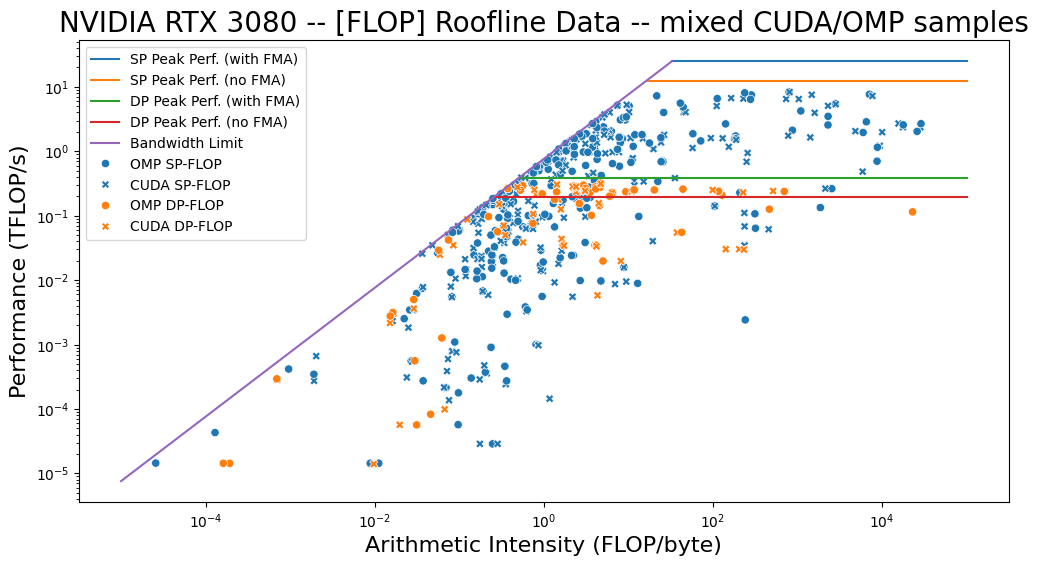

In [128]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))



# plot the SPOPS roofline line
ax.plot([spOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [spOPMaxPerfTFLOP,spOPMaxPerfTFLOP], label='Peak SP TFLOP/s (with FMA)')

ax.plot([spOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [spOPMaxPerfTFLOP/2,spOPMaxPerfTFLOP/2], label='Peak SP TFLOP/s (no FMA)')

# plot the DPOPS roofline line
ax.plot([dpOPMaxPerfTFLOP/maxBandwidthTBPerSec, 1e5], [dpOPMaxPerfTFLOP,dpOPMaxPerfTFLOP], label='Peak DP TFLOP/s (with FMA)')

ax.plot([dpOPMaxPerfTFLOP/(2*maxBandwidthTBPerSec), 1e5], [dpOPMaxPerfTFLOP/2,dpOPMaxPerfTFLOP/2], label='Peak DP TFLOP/s (no FMA)')

# plot the roofline slanted line
ax.plot([1e-5, spOPMaxPerfTFLOP/maxBandwidthTBPerSec], [maxBandwidthTBPerSec*1e-5,spOPMaxPerfTFLOP], label='Max Bandwidth')

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax, style='language')
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax, style='language')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title(f'{gpuName} -- [FLOP] Roofline Data -- mixed CUDA/OMP samples', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (TFLOP/s)', fontsize=16)

legend = ax.legend()
legend.labels = [ 'SP Peak Perf. (with FMA)', 'SP Peak Perf. (no FMA)', 'DP Peak Perf. (with FMA)', 'DP Peak Perf. (no FMA)', 'Bandwidth Limit', 'OMP SP-FLOP', 'CUDA SP-FLOP', 'OMP DP-FLOP', 'CUDA DP-FLOP']
ax.legend(legend.legend_handles, legend.labels)

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

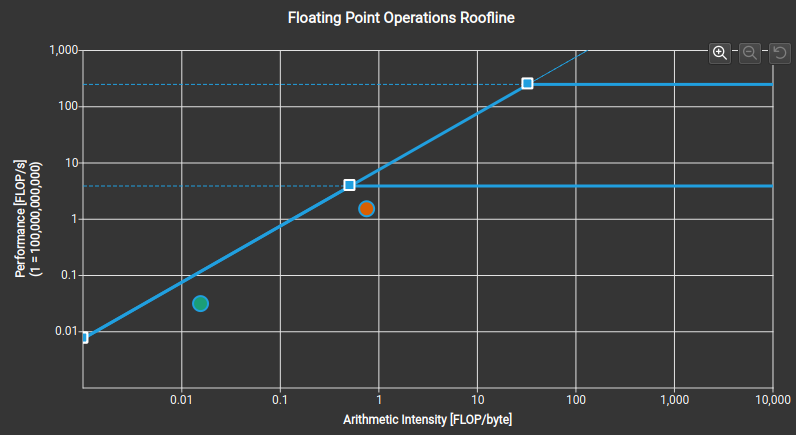

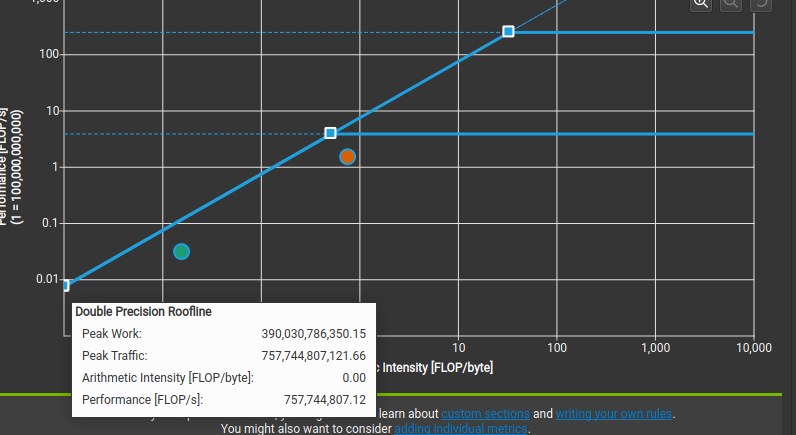

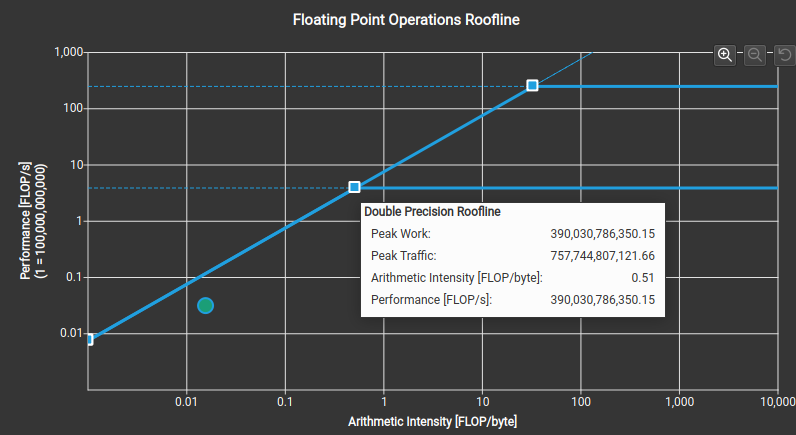

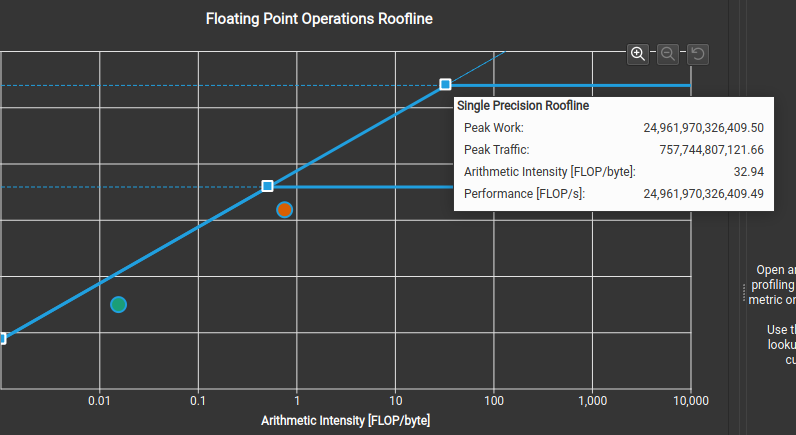

### Check the distribution of arithmetic intensity

### Let's add a column as a bandwidth-bound indicator

In [129]:
# This is only classifying a code as Bandwidth-Bound because of its Single-Precision behavior
# Sometimes the SP is really low because a code is doing DP ops, so it may not be BB
#df['isBB'] = df['spAI'] < balancePointSPFLOPPerByte

# We instead opt to check if the code is BB relative to all 3 metrics (intOP, spFLOP, dpFLOP)
# where each metric is checked against its respective balance point.
# If the LLM is smart enough, it should recognize the types of operations a code is doing and then
# be able to classify which roofline it belongs to.
df['isBB'] = (df['spAI'] < balancePointSPFLOPPerByte) & (df['dpAI'] < balancePointDPFLOPPerByte) & (df['intAI'] < balancePointINTOPPerByte)

df['isBB'] = df['isBB'].apply(lambda x: 1 if x else 0)

df['class'] = df['isBB'].apply(lambda x: 'Bandwidth-bound' if x==1 else 'Compute-Bound')
df['answer'] = df['isBB'].apply(lambda x: 'Bandwidth' if x==1 else 'Compute')

In [130]:
print(df.head())

                                         Kernel Name       traffic      dpAI  \
0  haccmk_kernel(int, int, const float *, const f...  7.156462e+07  0.000000   
1  bit_rev_permutation(long *, const long *, unsi...  4.585366e+09  0.000000   
2  bit_rev_permutation_z(long *, const long *, un...  6.496454e+09  0.000000   
3  initial_value(unsigned int, double, double, do...  2.528404e+10  9.317279   
4  solve(unsigned int, double, double, double, do...  5.187426e+11  0.563661   

          spAI    dpPerf    spPerf      xtime    Block Size      Grid Size  \
0  1868.406255  0.000000  0.133712  2990528.0   (256, 1, 1)      (4, 1, 1)   
1     0.000000  0.000000  0.000000     3936.0  (1024, 1, 1)      (1, 1, 1)   
2     0.000000  0.000000  0.000000     4512.0    (32, 1, 1)      (2, 1, 1)   
3     0.409507  0.235578  0.010354  6480864.0   (256, 1, 1)  (65536, 1, 1)   
4     0.000000  0.292395  0.000000   516416.0   (256, 1, 1)  (65536, 1, 1)   

                    device  ...       intAI       

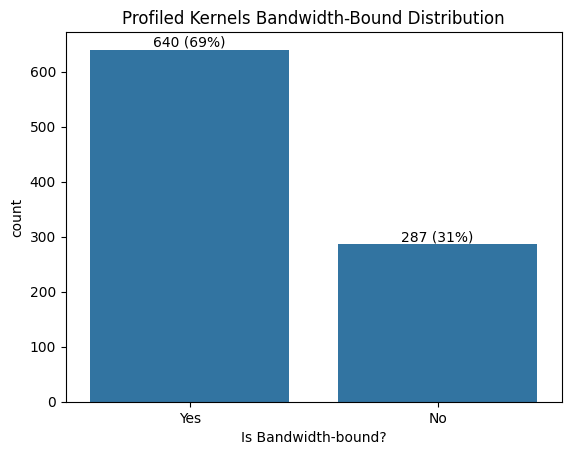

In [131]:
# let's plot the distribution

ax = sns.countplot(data=df, order=df['isBB'].value_counts(ascending=False).index, x='isBB')

abs_values = df['isBB'].value_counts(ascending=False)
rel_values = df['isBB'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Profiled Kernels Bandwidth-Bound Distribution')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()

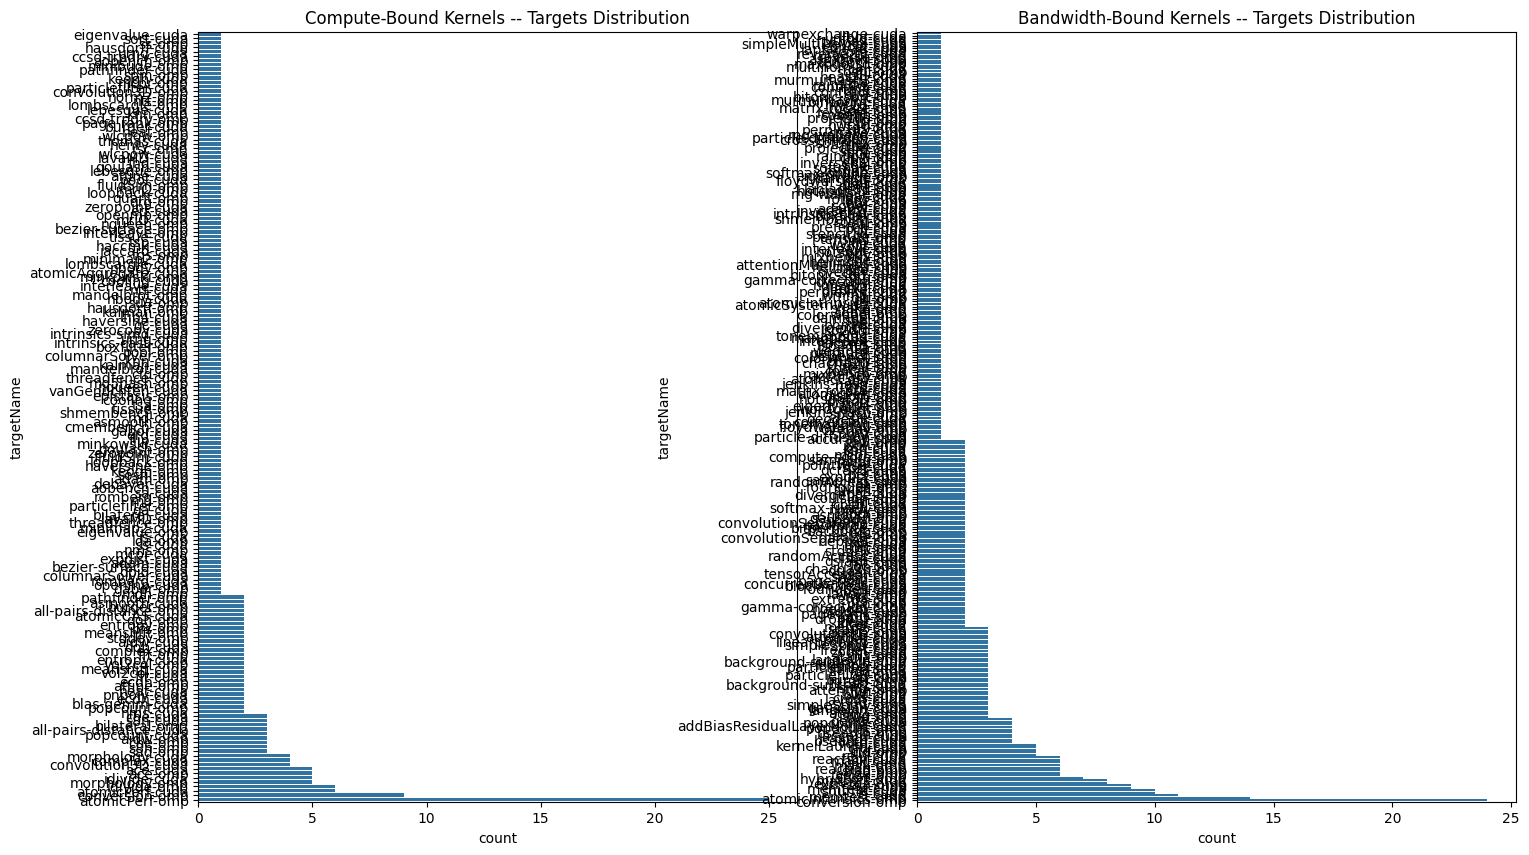

In [132]:
# now let's check how many kernels that are NOT BB come from the same program

cbKernels = df[df['isBB'] == 0].copy()
bbKernels = df[df['isBB'] == 1].copy()

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

sns.countplot(data=cbKernels, order=cbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[0])
sns.countplot(data=bbKernels, order=bbKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[1])

axs[0].set_title('Compute-Bound Kernels -- Targets Distribution')
axs[1].set_title('Bandwidth-Bound Kernels -- Targets Distribution')

plt.show()

In [133]:
# let's check if there's any overlap in targetNames from the datasets


common = set(cbKernels['targetName']) & set(bbKernels['targetName'])

print(common)
print()
print(f'The Compute-Bound (CB) and Bandwidth-Bound (BB) subsets have {len(common)} executables in common')
print()

print('Number of kernels for each common executable')

cbCounts = cbKernels.groupby(['targetName'])['Kernel Name'].count().reset_index().sort_values(by=['targetName'])
bbCounts = bbKernels.groupby(['targetName'])['Kernel Name'].count().reset_index().sort_values(by=['targetName'])

cbCounts = cbCounts[cbCounts['targetName'].isin(common)]
bbCounts = bbCounts[bbCounts['targetName'].isin(common)]

cbCounts.set_index('targetName', inplace=True)
bbCounts.set_index('targetName', inplace=True)

allCounts = pd.DataFrame(index=cbCounts.index)

allCounts['cbCounts'] = cbCounts['Kernel Name']
allCounts['bbCounts'] = bbCounts['Kernel Name']

print(allCounts.sort_values(by=['bbCounts', 'cbCounts'], ascending=False))



{'boxfilter-omp', 'popcount-cuda', 'burger-cuda', 'burger-omp', 'lfib4-cuda', 'gc-cuda', 'popcount-omp', 'mcpr-omp', 'knn-cuda', 'eigenvalue-omp', 'page-rank-omp', 'sa-cuda', 'jaccard-cuda', 'intrinsics-cast-cuda', 'mriQ-omp', 'asmooth-cuda', 'expdist-cuda', 'is-cuda', 'nbody-omp', 'ace-cuda', 'asmooth-omp', 'atomicPerf-omp', 'mcpr-cuda', 'nbody-cuda', 'mriQ-cuda', 'interleave-cuda', 'interleave-omp', 'stddev-omp', 'nms-omp', 'dpid-cuda', 'eigenvalue-cuda', 'ace-omp', 'knn-omp', 'particlefilter-omp', 'particlefilter-cuda', 'sosfil-omp', 'tsa-omp', 'che-cuda', 'heat-omp', 'conversion-omp', 'qrg-cuda', 'qrg-omp', 'cfd-omp', 'sort-cuda', 'che-omp', 'heat-cuda'}

The Compute-Bound (CB) and Bandwidth-Bound (BB) subsets have 46 executables in common

Number of kernels for each common executable
                      cbCounts  bbCounts
targetName                              
conversion-omp               9        24
is-cuda                      1        10
sa-cuda                      1      

### Visualize the token count distribution

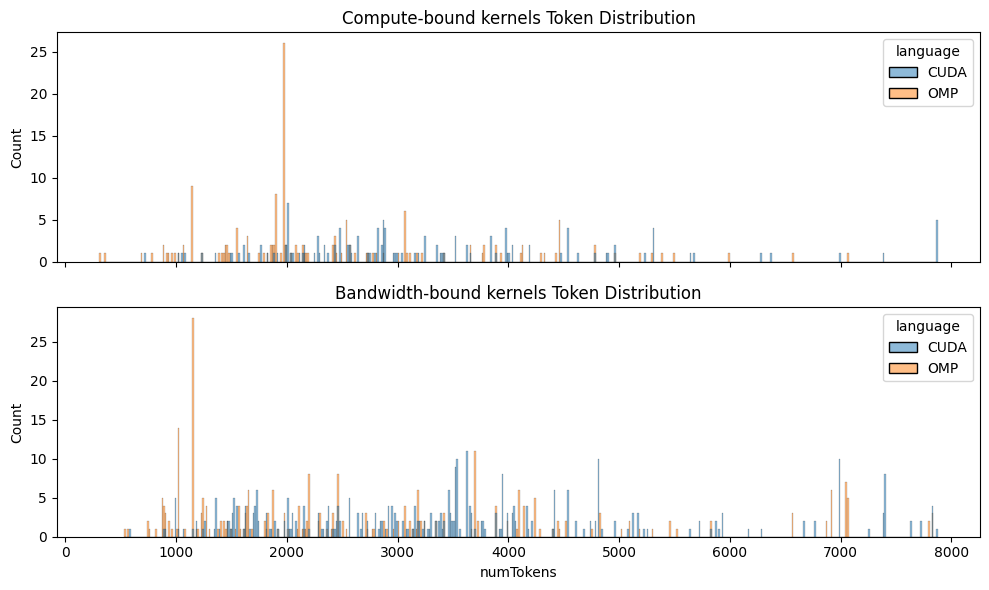

In [134]:

#fig = px.histogram(df[df['isBB'] == 0], x="numTokens", color="language", marginal='rug', nbins=500, title='Compute-bound kernels Token Distribution')
#fig.show()
#fig = px.histogram(df[df['isBB'] == 1], x="numTokens", color="language", marginal='rug', nbins=500, title='Bandwidth-bound kernels Token Distribution')
#fig.show()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Compute-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 0], x="numTokens", hue="language", kde=False, bins=500, ax=axes[0])
axes[0].set_title('Compute-bound kernels Token Distribution')

# Bandwidth-bound kernels Token Distribution
sns.histplot(data=df[df['isBB'] == 1], x="numTokens", hue="language", kde=False, bins=500, ax=axes[1])
axes[1].set_title('Bandwidth-bound kernels Token Distribution')

# Adjust layout
plt.tight_layout()
plt.show()

### Target deduplication

Because each kernel of each target is mapped to the same source code, we don't want to have multiple kernels of one target of the same boundedness class in the training/testing datasets, as our model might over-train on the similar repeat data.

In [135]:
# now we want to pick at most 1 sample of a targetName from the CB and BB set
# this is because although we may pick 2 different kernels, they map to the same code
# so 

print(df.columns)

# we indiscriminately pick the samples with the smallest token counts in each group
singleSubset = df.loc[df.groupby(['targetName', 'exeArgs', 'isBB', 'language', 'device']).numTokens.idxmin()]

print(singleSubset.columns)

singleSubset = singleSubset.reset_index(drop=True)

print(singleSubset.columns)

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')


Number of sampled executables 433


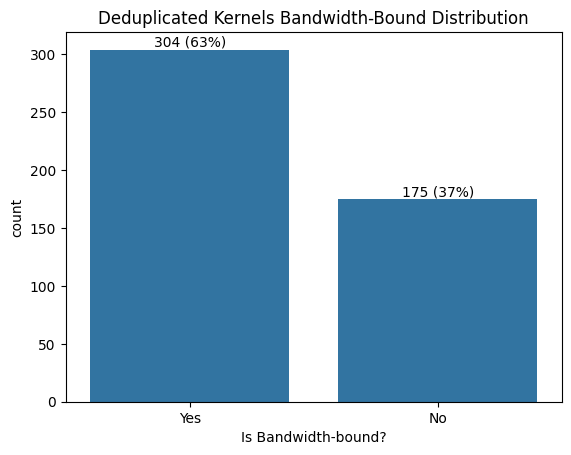

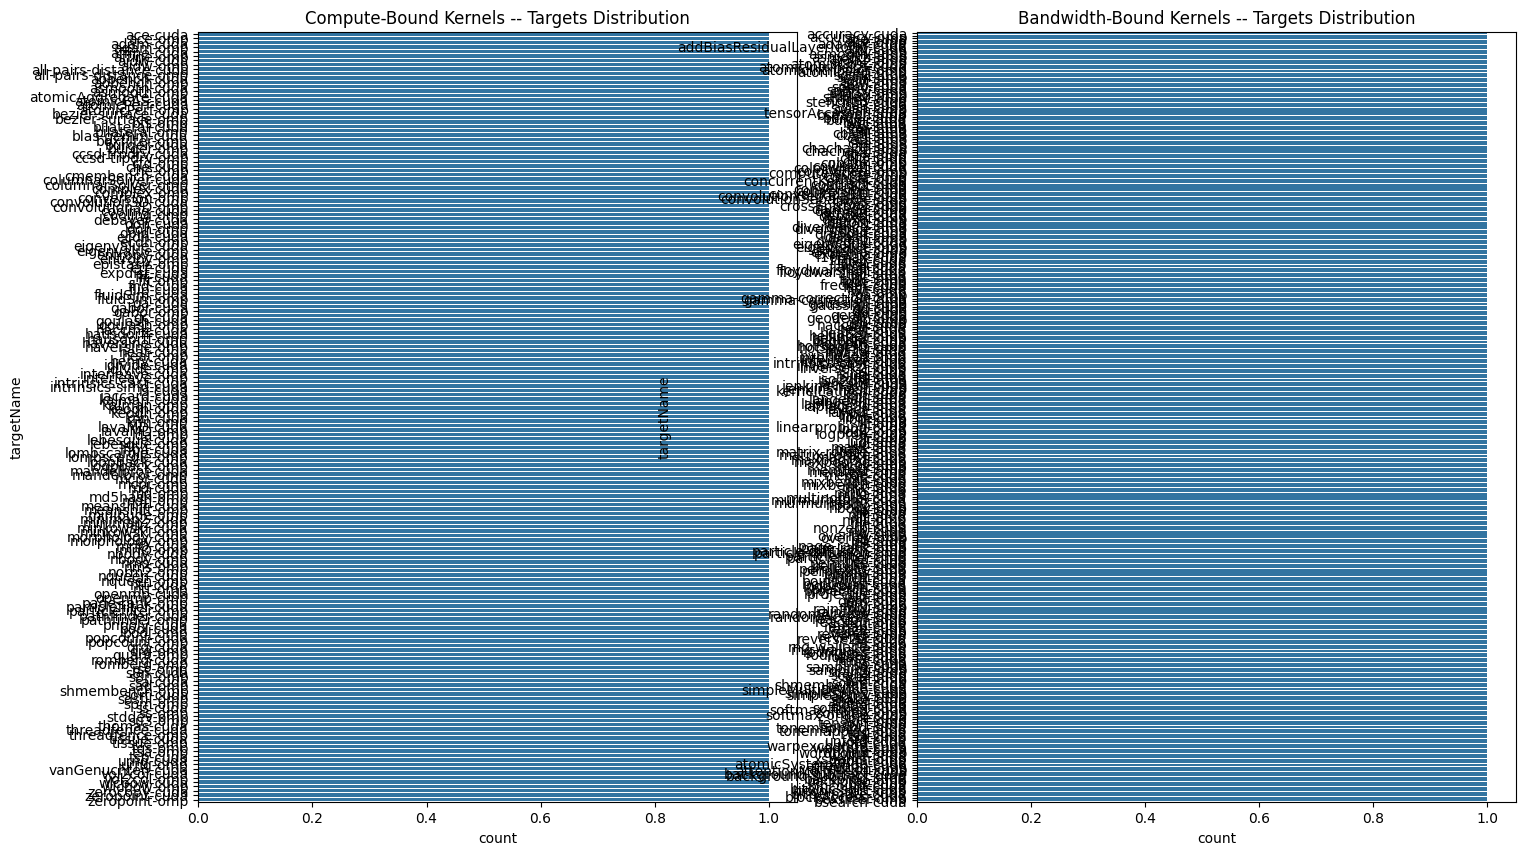

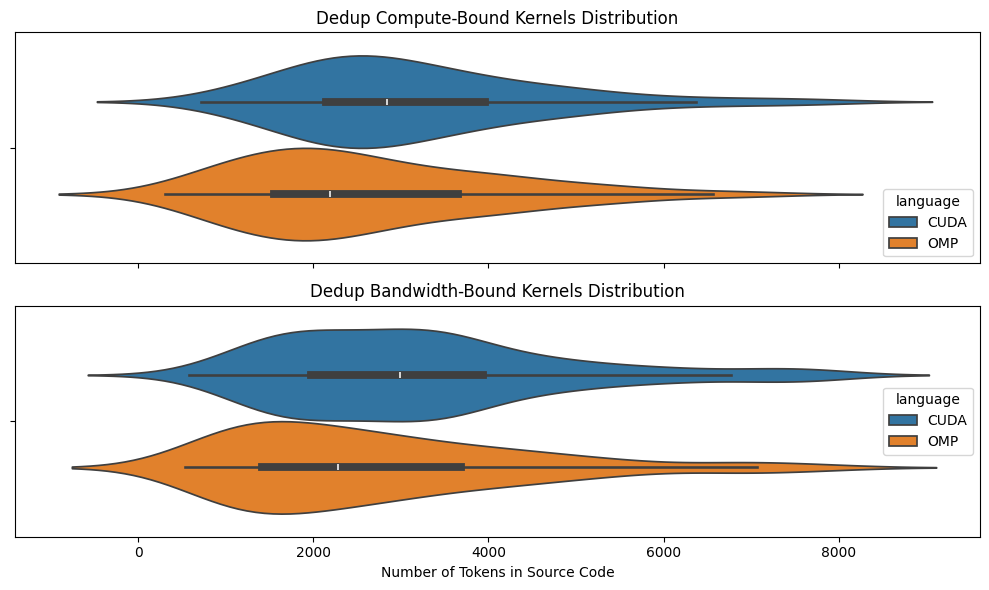

In [136]:
print('Number of sampled executables', df.groupby(['targetName']).ngroups)

ax = sns.countplot(data=singleSubset, order=singleSubset['isBB'].value_counts(ascending=False).index, x='isBB')

abs_values = singleSubset['isBB'].value_counts(ascending=False)
rel_values = singleSubset['isBB'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_xlabel('Is Bandwidth-bound?')
ax.set_title('Deduplicated Kernels Bandwidth-Bound Distribution')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()


subsetCBKernels = singleSubset[singleSubset['isBB'] == 0]
subsetBBKernels = singleSubset[singleSubset['isBB'] == 1]

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

sns.countplot(data=subsetCBKernels, order=subsetCBKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[0])
sns.countplot(data=subsetBBKernels, order=subsetBBKernels['targetName'].value_counts(ascending=True).index, y='targetName', ax = axs[1])

axs[0].set_title('Compute-Bound Kernels -- Targets Distribution')
axs[1].set_title('Bandwidth-Bound Kernels -- Targets Distribution')

plt.show()



# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Dedup Compute-Bound Kernels Distribution
sns.violinplot(data=subsetCBKernels, x="numTokens", hue="language",  ax=axes[0]) #kde=False, bins=1000,
axes[0].set_title('Dedup Compute-Bound Kernels Distribution')
axes[0].set_xlabel('Number of Tokens in Source Code')

# Dedup Bandwidth-Bound Kernels Distribution
sns.violinplot(data=subsetBBKernels, x="numTokens", hue="language",  ax=axes[1]) #kde=False, bins=1000,
axes[1].set_title('Dedup Bandwidth-Bound Kernels Distribution')
axes[1].set_xlabel('Number of Tokens in Source Code')

# Adjust layout
plt.tight_layout()
plt.show()


In [137]:
# for this inference dataset, we want to have it split 50-50 between BB and CB samples
# let's be sure to grab the overlap common executables, and then random remaining BB executables

# from our previous cell, we know that 20 executables are in both the CB and BB samples -- these will test the LLMs reasoning the most


cbInfKernels = subsetCBKernels.copy()

bbInfKernels = subsetBBKernels[subsetBBKernels['targetName'].isin(cbInfKernels['targetName'].tolist())]


print(cbInfKernels.shape)
print(cbInfKernels.columns)
print(bbInfKernels.shape)

(175, 22)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')
(46, 22)


In [138]:
# now let's add in the remaining samples to the bbInfKernels

notInBBInf = subsetBBKernels[~subsetBBKernels['targetName'].isin(bbInfKernels['targetName'].tolist())]

# evenly distribute the token counts
notInBBInf = notInBBInf.sort_values(by=['numTokens'], ascending=True)

# drop any that have more tokens than the max tokens of the CB set
notInBBInf = notInBBInf[notInBBInf['numTokens'] <= cbInfKernels['numTokens'].max()]

numToSample = cbInfKernels.shape[0]-bbInfKernels.shape[0]
assert numToSample >= 0

# randomly subsample -- we should instead sort by number of tokens, then uniformly random sample it
# we use a seed for consistency
notInBBInf = notInBBInf.sample(n=numToSample, random_state=183792)

bbInfKernels = pd.concat([bbInfKernels, notInBBInf], ignore_index=True)

In [139]:
print(bbInfKernels.shape)
print(cbInfKernels.shape)
print(bbInfKernels.columns)

(175, 22)
(175, 22)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')


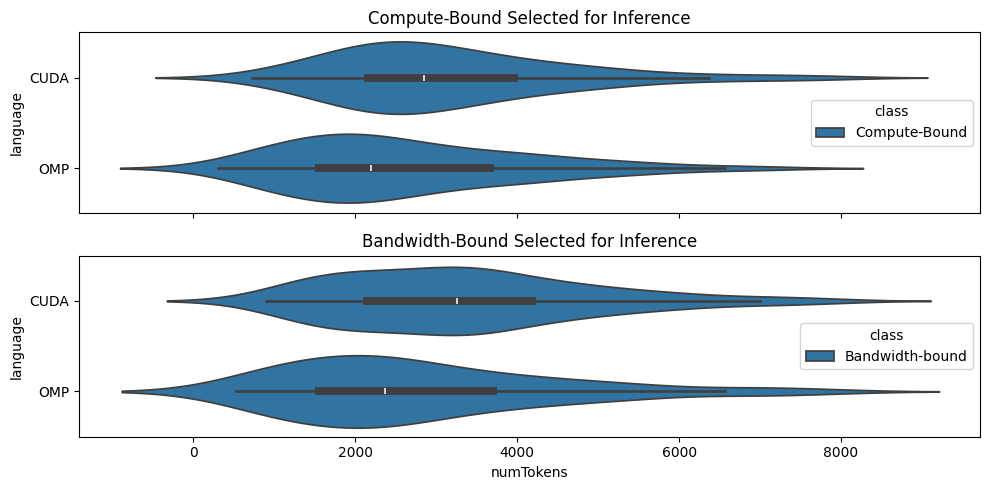

In [140]:

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Compute-Bound Selected for Inference
sns.violinplot(data=cbInfKernels, x="numTokens", y="language", hue="class", ax=axes[0], inner="box")
axes[0].set_title('Compute-Bound Selected for Inference')

# Bandwidth-Bound Selected for Inference
sns.violinplot(data=bbInfKernels, x="numTokens", y="language", hue="class", ax=axes[1], inner="box")
axes[1].set_title('Bandwidth-Bound Selected for Inference')

# Adjust layout
plt.tight_layout()
plt.show()

### Plot the Arithmetic Intensity Distribution of the balanced datasets

In [141]:
print(cbInfKernels.columns)
print(cbInfKernels.shape)
print(bbInfKernels.shape)

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')
(175, 22)
(175, 22)


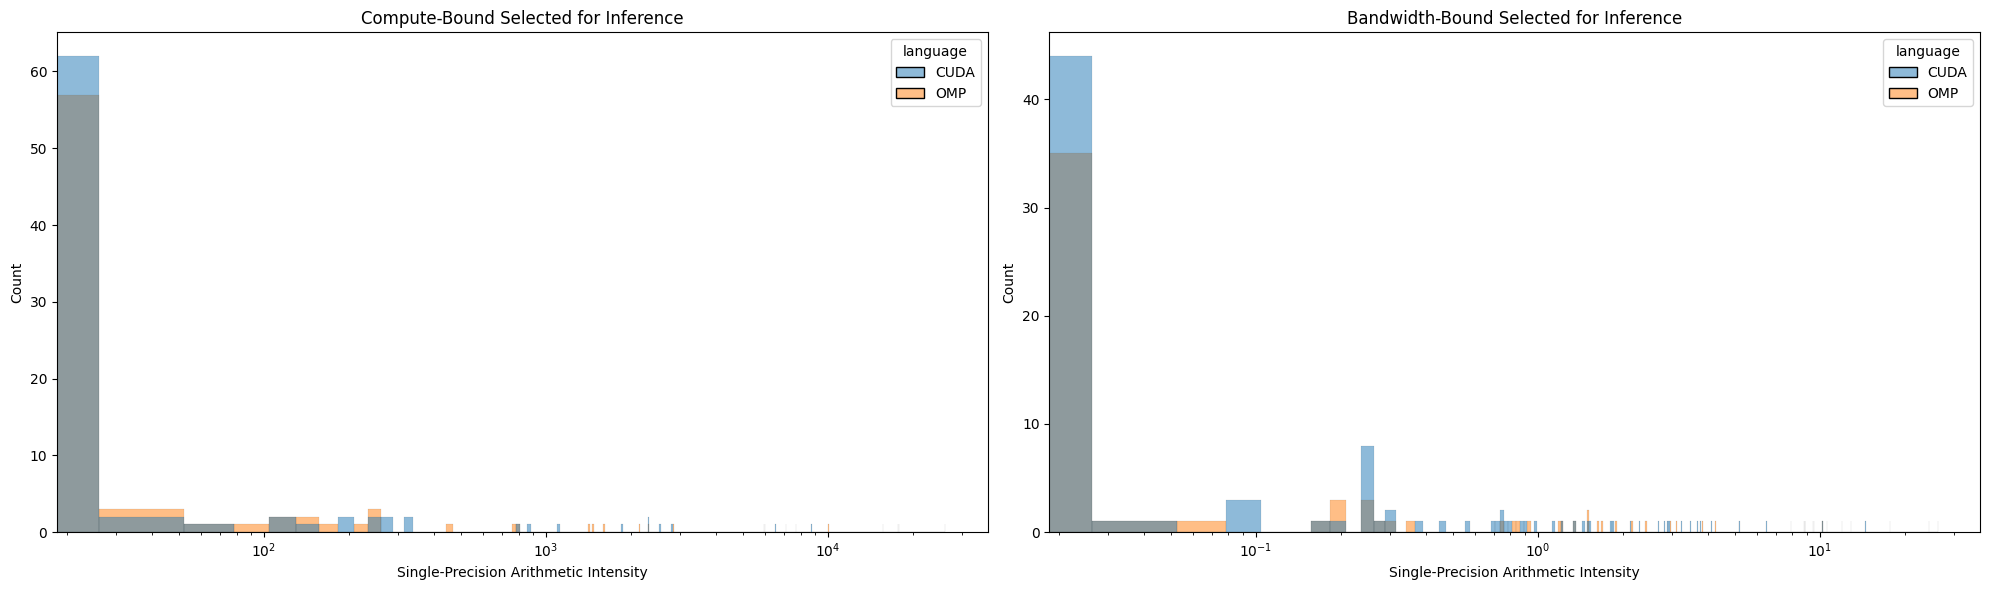

In [142]:


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Compute-Bound Selected for Inference
sns.histplot(data=cbInfKernels, x="spAI", hue="language", kde=False, bins=1000, ax=axes[0])
axes[0].set_title('Compute-Bound Selected for Inference')
axes[0].set_xlabel('Single-Precision Arithmetic Intensity')
axes[0].set_xscale('log')

# Bandwidth-Bound Selected for Inference
sns.histplot(data=bbInfKernels, x="spAI", hue="language", kde=False, bins=1000, ax=axes[1])
axes[1].set_title('Bandwidth-Bound Selected for Inference')
axes[1].set_xlabel('Single-Precision Arithmetic Intensity')
axes[1].set_xscale('log')

# Display the plots
plt.tight_layout()
plt.show()


## Create a training-test split

In [143]:
cbInfKernels = cbInfKernels.reset_index(drop=True)
bbInfKernels = bbInfKernels.reset_index(drop=True)

print(cbInfKernels.columns)

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')


In [144]:

# this does uniform sampling 
cbTrain, cbVal, bbTrain, bbVal = train_test_split(cbInfKernels, bbInfKernels, random_state=13804,  test_size=0.2,  shuffle=True) 


print(cbTrain.shape, bbTrain.shape, cbVal.shape, bbVal.shape)

(140, 22) (140, 22) (35, 22) (35, 22)


In [145]:
trainDF = pd.concat([cbTrain, bbTrain], ignore_index=True)
valDF = pd.concat([cbVal, bbVal], ignore_index=True)

### Check the distribution of the training + test data


Technically it's balanced in terms of CB and BB samples, but not in Grid/Block Size

             class  Kernel Name  traffic  dpAI  spAI  dpPerf  spPerf  xtime  \
0  Bandwidth-bound          140      140   140   140     140     140    140   
1    Compute-Bound          140      140   140   140     140     140    140   

   Block Size  Grid Size  ...  intPerf  intAI  targetName  exeArgs  \
0         140        140  ...      140    140         140      140   
1         140        140  ...      140    140         140      140   

   kernelName  language  numTokens  kernelCode  isBB  answer  
0         140       140        140         140   140     140  
1         140       140        140         140   140     140  

[2 rows x 22 columns]


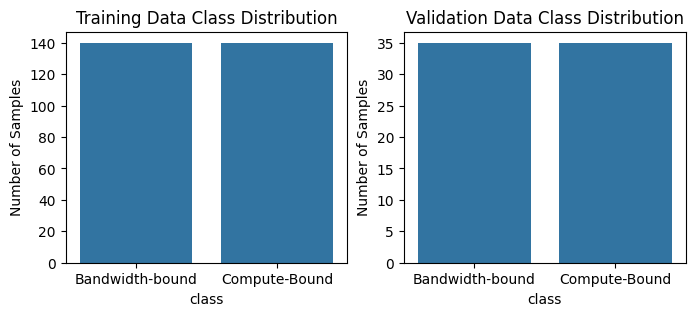

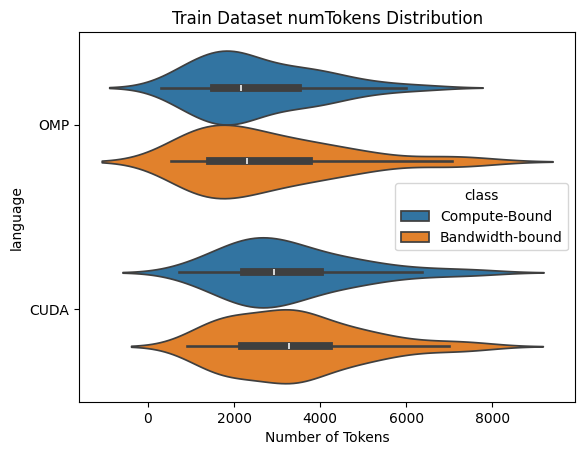

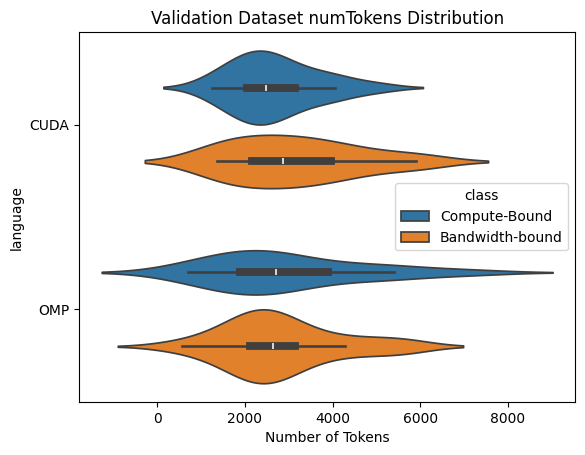

In [146]:
# These should show an even number of compute-bound and bandwidth-bound samples in each dataset

trainToPlot = trainDF.groupby(['class']).count().reset_index()
print(trainToPlot)
valToPlot = valDF.groupby(['class']).count().reset_index()


fig, axs = plt.subplots(1,2, figsize=(8,3))
sns.barplot(data=trainToPlot, x='class', y='Kernel Name', ax = axs[0])
sns.barplot(data=valToPlot, x='class', y='Kernel Name', ax = axs[1])
axs[0].set_title('Training Data Class Distribution')
axs[0].set_ylabel('Number of Samples')
axs[1].set_title('Validation Data Class Distribution')
axs[1].set_ylabel('Number of Samples')
plt.show()

ax = sns.violinplot(trainDF, x="numTokens", y='language', hue="class", inner='box')
ax.set_title('Train Dataset numTokens Distribution')
ax.set_xlabel('Number of Tokens')
plt.show()
ax = sns.violinplot(valDF, x="numTokens", y='language', hue="class", inner='box')
ax.set_title('Validation Dataset numTokens Distribution')
ax.set_xlabel('Number of Tokens')
plt.show()

### Write out a file for training and another for testing, also write out all the samples for zero-shot inference

#### Writing to files

In [147]:
print(trainDF.columns)
print(trainDF.head())

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')
                                         Kernel Name       traffic      dpAI  \
0           __omp_offloading_10309_2fc4989_main_l121  9.358064e+08  0.000000   
1  k_slow(int, int, int, int *, int *, unsigned i...  1.943966e+10  0.000000   
2  initial_value(unsigned int, double, double, do...  2.528404e+10  9.317279   
3            __omp_offloading_10309_2f0470f_main_l77  3.252347e+11  0.774723   
4  __omp_offloading_10309_2fc44b2__Z11EstepKernel...  1.217988e+10  0.000000   

          spAI    dpPerf    spPerf       xtime   Block Size       Grid Size  \
0  7712.122779  0.000000  7.217054    486528.0  (256, 1, 1)     (391, 1, 1)   
1     0.000000  0.000000  0.000000  21600608.0  (256, 1, 1)  (19531

In [148]:
trainDF.to_csv('train-dataset.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 
valDF.to_csv('validation-dataset.csv', quoting=csv.QUOTE_NONNUMERIC, quotechar='\"', index=False, na_rep='NULL') 

In [ ]:
await write_df_to_jsonl(trainDF, 'train-dataset', True)
await write_df_to_jsonl(valDF, 'validation-dataset', True)


100%|██████████| 70/70 [00:00<00:00, 111.35it/s]


In [150]:

print(trainDF.dtypes)

Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
language               object
numTokens               int64
kernelCode             object
isBB                    int64
class                  object
answer                 object
dtype: object


# IGNORE BELOW

### Visualize Arithmetic Intensity + Performance of the Kernels 

In [40]:
print(df.columns)


Index(['index', 'Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf',
       'xtime', 'Block Size', 'Grid Size', 'device', 'intops', 'intPerf',
       'intAI', 'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer'],
      dtype='object')


In [41]:
# how many different kernel invocations did we capture?
totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 433
Total unique kernel executions recorded: 884
Number of kernels with no arithmetic intensity (AI) 388 (43.89%)
Number of non-zero AI single-precision kernels recorded: 453 (51.24%)
Number of non-zero AI double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf single-precision kernels recorded: 453 (51.24%)
Number of non-zero Perf double-precision kernels recorded: 100 (11.31%)
Number of non-zero Perf intop kernels recorded: 884 (100.0%)
Number of non-zero AI intop kernels recorded: 884 (100.0%)


In [42]:
spData = df[(df['spAI'] > 0)]
dpData = df[(df['dpAI'] > 0)]

#subdata = df[(df['spPerf'] > 0) | (df['dpPerf'] > 0) | (df['spAI'] > 0) | (df['dpAI'] > 0) ]
print('SP data')
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

print()
print('DP data')
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

SP data
spPerf        8.331123
dpPerf        0.320184
spAI      28944.779580
dpAI        699.293698
dtype: float64
spPerf    0.000014
dpPerf    0.000000
spAI      0.000026
dpAI      0.000000
dtype: float64
spPerf    0.184143
dpPerf    0.000000
spAI      1.427302
dpAI      0.000000
dtype: float64
spPerf      0.952591
dpPerf      0.021161
spAI      526.611785
dpAI        4.659862
dtype: float64

DP data
spPerf        2.661198
dpPerf        0.320184
spAI        314.330898
dpAI      23004.943886
dtype: float64
spPerf    0.000000
dpPerf    0.000014
spAI      0.000000
dpAI      0.000162
dtype: float64
spPerf    0.000545
dpPerf    0.143716
spAI      0.011182
dpAI      1.736067
dtype: float64
spPerf      0.107592
dpPerf      0.140646
spAI       13.047191
dpAI      262.570657
dtype: float64


In [43]:

def plotAIHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spAI', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpAI', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intAI', ax=ax2)
    sns.ecdfplot(subdf, x='spAI', ax=ax2)
    sns.ecdfplot(subdf, x='dpAI', ax=ax2)

    ax.set_xlabel('Arithmetic Intensity (TeraOP/byte)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Arithmetic Intensity {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

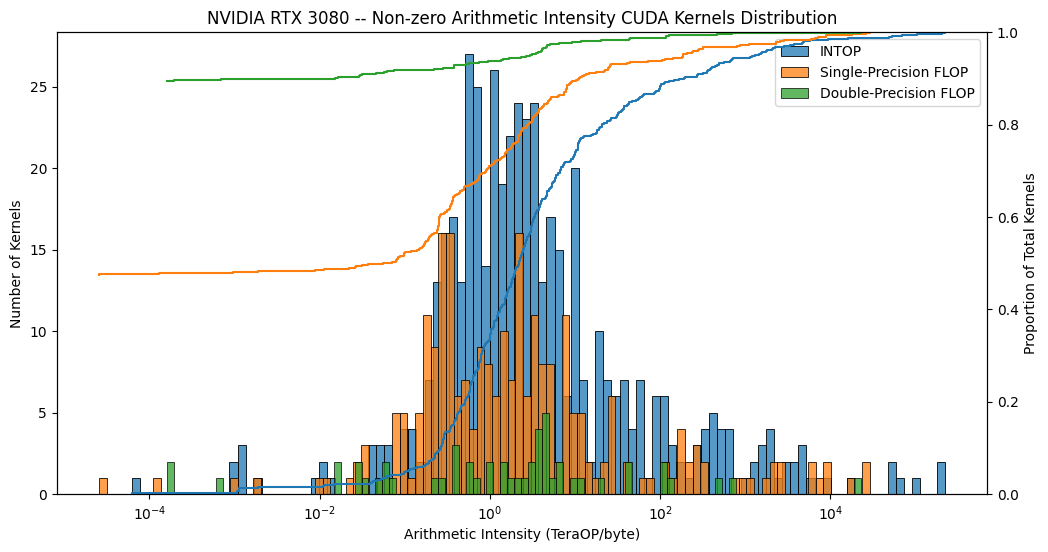

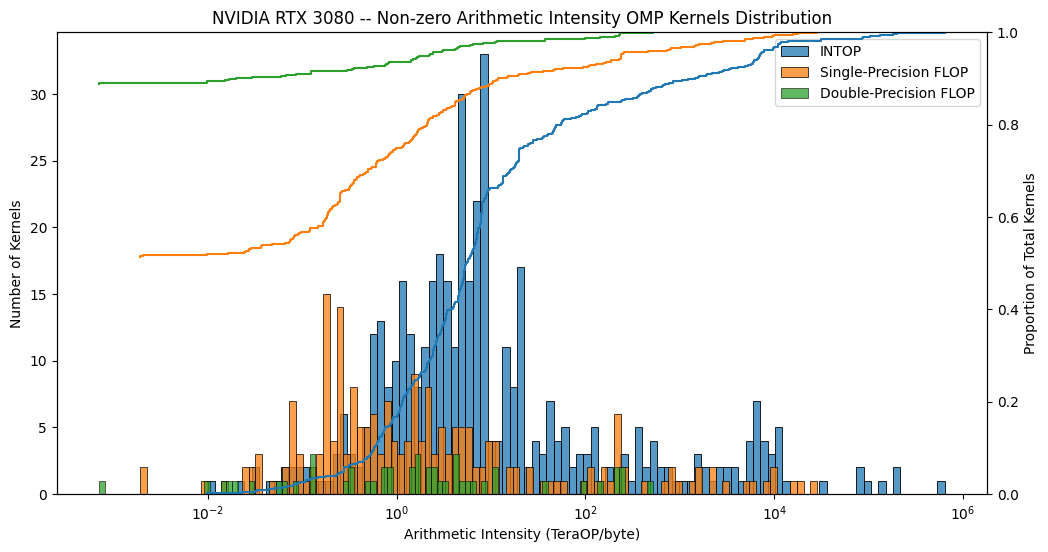

In [44]:
plotAIHistogram(df, 'CUDA')
plotAIHistogram(df, 'OMP')

In [45]:
#subdf = df[df['targetName'].isin(['bspline-vgh-cuda'])].copy().reset_index()
#
#print(subdf)
#
#print(type(subdf.iloc[0]['exeArgs']))
#
#grpA = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs'])
#grpB = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size'])
#
#
#print(grpA)
#print(grpB)
#
#print(grpA.ngroups)
#print(grpB.ngroups)

In [46]:
# what does the AI distribution look like? (violin plot + histogram)

def plotPerfHistogram(df, language):
    fig, ax = plt.subplots(1, figsize=(12,6))

    subdf = df[df['language'] == language]

    sns.histplot(subdf, x='intPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='spPerf', bins=100, ax=ax, log_scale=True)
    sns.histplot(subdf, x='dpPerf', bins=100, ax=ax, log_scale=True)
    ax2 = ax.twinx()
    sns.ecdfplot(subdf, x='intPerf', ax=ax2)
    sns.ecdfplot(subdf, x='spPerf', ax=ax2)
    sns.ecdfplot(subdf, x='dpPerf', ax=ax2)

    ax.set_xlabel('Performance (TeraOP/s)')
    ax.set_ylabel('Number of Kernels')
    ax2.set_ylabel('Proportion of Total Kernels')

    ax.set_title(f'{gpuName} -- Non-zero Performance {language} Kernels Distribution')

    ax.legend(['INTOP', 'Single-Precision FLOP', 'Double-Precision FLOP'])

    plt.show()

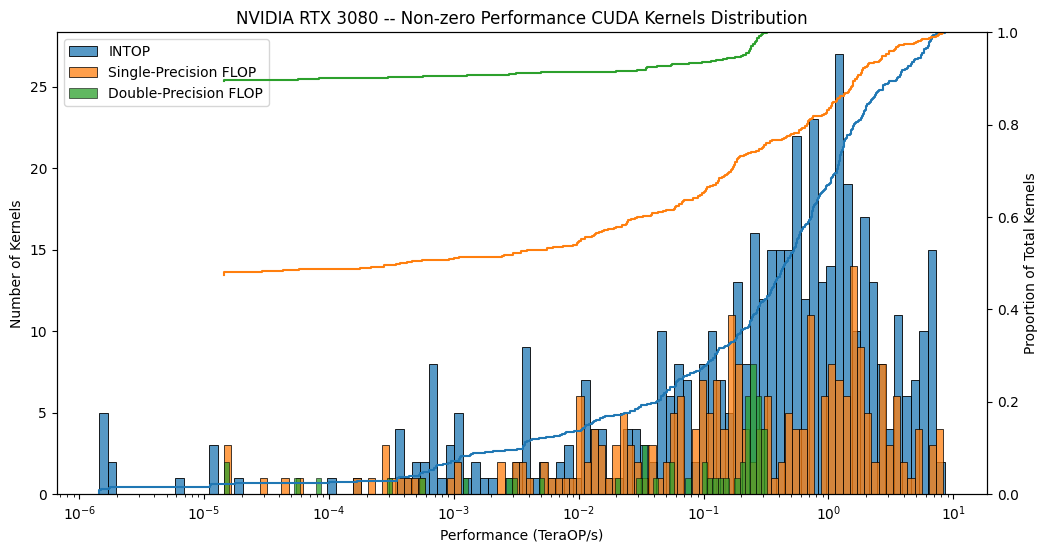

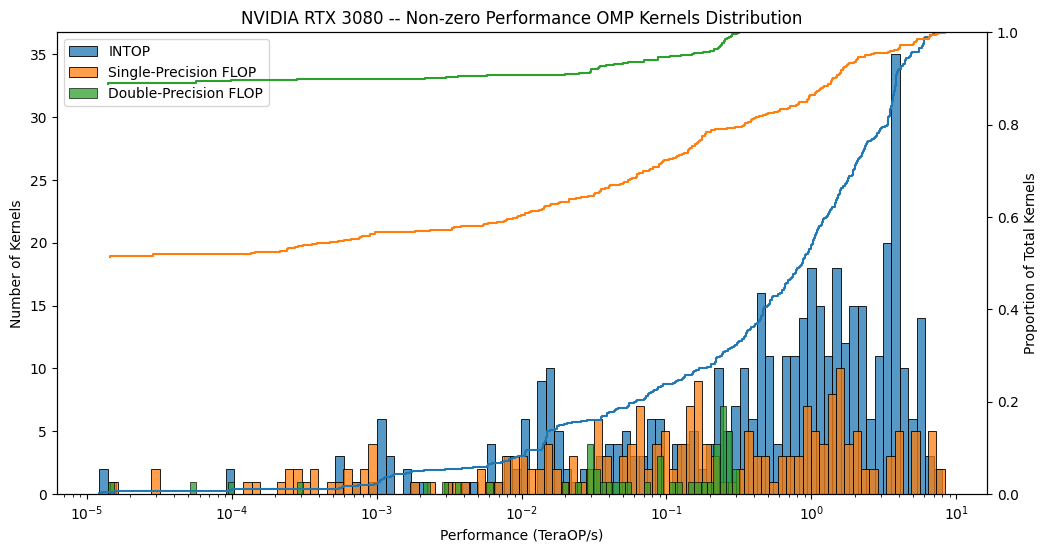

In [47]:
plotPerfHistogram(df, 'CUDA')
plotPerfHistogram(df, 'OMP')

### Visualize the Block and Grid Sizes

In [48]:
# because the sizes are in 3D, let's convert them to 1D by multiplying them


def strTupleTo1D(strTuple):
    finds = re.findall(r'\d+', strTuple)
    nums = [int(find) for find in finds]

    assert len(nums) == 3

    mult = 1
    for num in nums:
        mult = mult*num
    return mult


df['blockSz'] = df['Block Size'].apply(strTupleTo1D).astype(int)
df['gridSz'] = df['Grid Size'].apply(strTupleTo1D).astype(int)

print(df.head())


   index                                        Kernel Name       traffic  \
0      0  haccmk_kernel(int, int, const float *, const f...  7.156462e+07   
1      1  bit_rev_permutation(long *, const long *, unsi...  4.585366e+09   
2      2  bit_rev_permutation_z(long *, const long *, un...  6.496454e+09   
3      3  initial_value(unsigned int, double, double, do...  2.528404e+10   
4      4  solve(unsigned int, double, double, double, do...  5.187426e+11   

       dpAI         spAI    dpPerf    spPerf      xtime    Block Size  \
0  0.000000  1868.406255  0.000000  0.133712  2990528.0   (256, 1, 1)   
1  0.000000     0.000000  0.000000  0.000000     3936.0  (1024, 1, 1)   
2  0.000000     0.000000  0.000000  0.000000     4512.0    (32, 1, 1)   
3  9.317279     0.409507  0.235578  0.010354  6480864.0   (256, 1, 1)   
4  0.563661     0.000000  0.292395  0.000000   516416.0   (256, 1, 1)   

       Grid Size  ...    exeArgs             kernelName  language  numTokens  \
0      (4, 1, 1)  

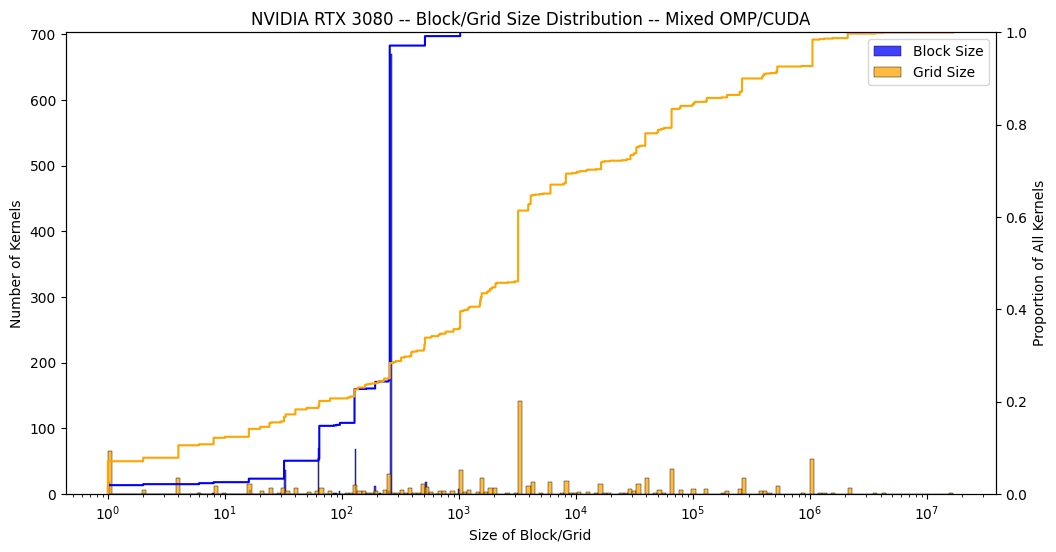

In [49]:

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='blockSz', bins=200, ax=ax, log_scale=True, color='blue')
#sns.histplot(df, x='blockSz', bins=100, ax=ax, log_scale=True, hue='language')
sns.histplot(df, x='gridSz', bins=200, ax=ax, log_scale=True, color='orange')
#sns.histplot(df, x='gridSz', bins=100, ax=ax, log_scale=True, hue='language')
ax2 = ax.twinx()
sns.ecdfplot(df, x='blockSz', ax=ax2, color='blue')
sns.ecdfplot(df, x='gridSz', ax=ax2, color='orange')
#sns.ecdfplot(df, x='blockSz', ax=ax2, hue='language')
#sns.ecdfplot(df, x='gridSz', ax=ax2, hue='language')

ax.set_xlabel('Size of Block/Grid')
ax.set_ylabel('Number of Kernels')
ax2.set_ylabel('Proportion of All Kernels')

ax.set_title(f'{gpuName} -- Block/Grid Size Distribution -- Mixed OMP/CUDA')

ax.legend(['Block Size', 'Grid Size'])
#ax2.legend()

plt.show()

In [50]:
# let's print the top 5 grid sizes and top 5 block sizes

#topBlockSzs = df.groupby('blockSz', 'language').count().reset_index().nlargest(5, ['language', 'Kernel Name', 'blockSz']).reset_index(drop=True)[['blockSz', 'Kernel Name']]
topn = 10

topBlockSzsJoined = df.groupby(['blockSz']).count().reset_index()
topBlockSzsOverall = topBlockSzsJoined.nlargest(topn, ['Kernel Name', 'blockSz'])[['Kernel Name', 'blockSz']]
numKernels = topBlockSzsJoined['Kernel Name'].sum()
topBlockSzsOverall['percent'] = 100*topBlockSzsOverall['Kernel Name']/numKernels

topBlockSzsOverall = topBlockSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsOverall)

topBlockSzs = df.groupby(['blockSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'blockSz'])

numKernelsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP']['Kernel Name'].sum()

topBlockSzsCUDA = topBlockSzs[topBlockSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]
topBlockSzsOMP = topBlockSzs[topBlockSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'blockSz'])[['language', 'Kernel Name', 'blockSz']]

topBlockSzsCUDA['percent'] = 100*topBlockSzsCUDA['Kernel Name']/numKernelsCUDA
topBlockSzsOMP['percent'] = 100*topBlockSzsOMP['Kernel Name']/numKernelsOMP

topBlockSzsCUDA = topBlockSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topBlockSzsOMP = topBlockSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topBlockSzsCUDA)
display(topBlockSzsOMP)


,Num Kernels,blockSz,percent
0,670,256,72.276160
1,68,128,7.335491
2,66,64,7.119741
3,36,32,3.883495
4,19,512,2.049622
5,18,1,1.941748
6,13,192,1.402373
7,8,1024,0.862999
8,7,16,0.755124
9,4,96,0.431499


,language,Num Kernels,blockSz,percent
0,CUDA,343,256,70.431211
1,CUDA,35,64,7.186858
2,CUDA,34,128,6.981520
3,CUDA,20,32,4.106776
4,CUDA,14,512,2.874743
5,CUDA,14,1,2.874743
6,CUDA,7,1024,1.437372
7,CUDA,7,192,1.437372
8,CUDA,3,16,0.616016
9,CUDA,2,96,0.410678


,language,Num Kernels,blockSz,percent
0,OMP,327,256,74.318182
1,OMP,34,128,7.727273
2,OMP,31,64,7.045455
3,OMP,16,32,3.636364
4,OMP,6,192,1.363636
5,OMP,5,512,1.136364
6,OMP,4,16,0.909091
7,OMP,4,1,0.909091
8,OMP,2,250,0.454545
9,OMP,2,96,0.454545


In [51]:
# let's print the top 5 grid sizes and top 5 block sizes

topn = 10
topGridSzs = df.groupby(['gridSz', 'language']).count().reset_index()#.nlargest(5, ['language', 'Kernel Name', 'gridSz'])

topgridSzsJoined = df.groupby(['gridSz']).count().reset_index()
topgridSzsOverall = topgridSzsJoined.nlargest(topn, ['Kernel Name', 'gridSz'])[['Kernel Name', 'gridSz']]
numKernels = topgridSzsJoined['Kernel Name'].sum()
topgridSzsOverall['percent'] = 100*topgridSzsOverall['Kernel Name']/numKernels

topgridSzsOverall = topgridSzsOverall.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)

display(topgridSzsOverall)

numKernelsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA']['Kernel Name'].sum()
numKernelsOMP = topGridSzs[topGridSzs['language'] == 'OMP']['Kernel Name'].sum()

topGridSzsCUDA = topGridSzs[topGridSzs['language'] == 'CUDA'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]
topGridSzsOMP = topGridSzs[topGridSzs['language'] == 'OMP'].nlargest(topn, ['Kernel Name', 'gridSz'])[['language', 'Kernel Name', 'gridSz']]

topGridSzsCUDA['percent'] = 100*topGridSzsCUDA['Kernel Name']/numKernelsCUDA
topGridSzsOMP['percent'] = 100*topGridSzsOMP['Kernel Name']/numKernelsOMP

topGridSzsCUDA = topGridSzsCUDA.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
topGridSzsOMP = topGridSzsOMP.rename(columns={'Kernel Name':'Num Kernels'}).reset_index(drop=True)
display(topGridSzsCUDA)
display(topGridSzsOMP)


,Num Kernels,gridSz,percent
0,142,3200,15.318231
1,66,1,7.119741
2,53,1048576,5.717368
3,37,65536,3.991370
4,31,1024,3.344121
5,28,256,3.020496
6,25,39063,2.696872
7,25,4,2.696872
8,24,262144,2.588997
9,18,6048,1.941748


,language,Num Kernels,gridSz,percent
0,CUDA,47,1,9.650924
1,CUDA,33,65536,6.776181
2,CUDA,24,39063,4.928131
3,CUDA,18,1048576,3.696099
4,CUDA,17,262144,3.490760
5,CUDA,16,1024,3.285421
6,CUDA,14,256,2.874743
7,CUDA,13,4096,2.669405
8,CUDA,12,8192,2.464066
9,CUDA,12,3907,2.464066


,language,Num Kernels,gridSz,percent
0,OMP,142,3200,32.272727
1,OMP,35,1048576,7.954545
2,OMP,20,4,4.545455
3,OMP,19,1,4.318182
4,OMP,15,1024,3.409091
5,OMP,14,256,3.181818
6,OMP,12,6048,2.727273
7,OMP,7,262144,1.590909
8,OMP,7,16,1.590909
9,OMP,7,8,1.590909


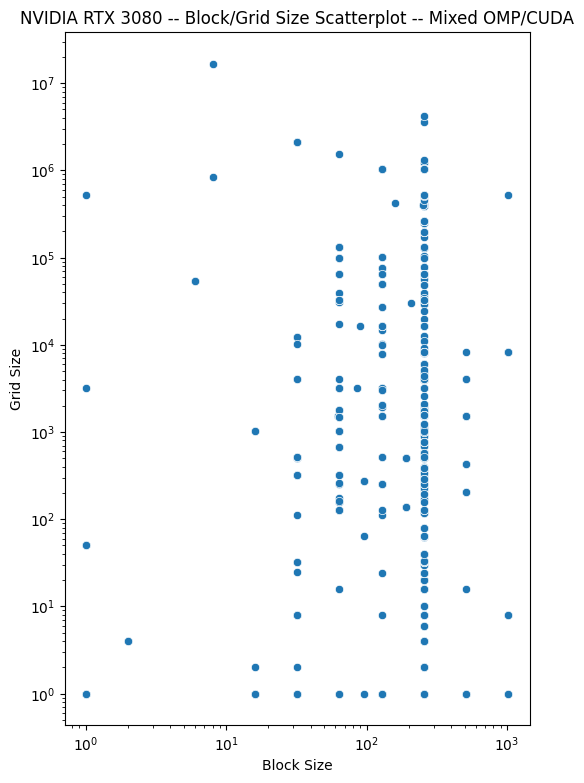

In [52]:

fig, ax = plt.subplots(1, figsize=(6,9))

sns.scatterplot(df, x='blockSz', y='gridSz', ax=ax)

ax.set_title(f'{gpuName} -- Block/Grid Size Scatterplot -- Mixed OMP/CUDA')
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Block Size')
ax.set_ylabel('Grid Size')

plt.show()

In [53]:
uniqBlockSzs = sorted(df['blockSz'].unique().tolist())
print(f'num unique block sizes: {len(uniqBlockSzs)}: {uniqBlockSzs}')

print()
uniqGridSzs = sorted(list(df['gridSz'].unique().tolist()))
print(f'num unique grid  sizes: {len(uniqGridSzs)}: {uniqGridSzs}')

num unique block sizes: 20: [1, 2, 6, 8, 16, 32, 63, 64, 85, 90, 96, 128, 160, 192, 208, 250, 255, 256, 512, 1024]

num unique grid  sizes: 153: [1, 2, 4, 6, 8, 10, 16, 20, 24, 25, 30, 32, 33, 40, 50, 63, 64, 79, 112, 118, 128, 137, 157, 161, 169, 176, 193, 204, 225, 229, 255, 256, 257, 274, 288, 320, 343, 380, 391, 400, 435, 500, 506, 510, 511, 512, 576, 588, 669, 693, 768, 899, 1000, 1017, 1022, 1024, 1088, 1130, 1200, 1236, 1500, 1513, 1524, 1525, 1531, 1536, 1563, 1737, 1792, 1844, 1849, 1898, 1920, 2048, 2088, 2605, 2997, 3200, 3907, 3969, 4096, 4225, 4429, 4883, 5184, 6048, 7813, 8000, 8160, 8184, 8192, 9216, 10000, 10240, 10929, 12208, 12500, 14826, 16384, 16650, 17536, 19532, 24692, 27000, 29184, 30307, 31250, 32768, 34200, 35344, 39063, 49152, 50176, 53568, 56133, 57404, 65536, 66016, 76800, 78125, 98304, 100096, 102400, 103680, 129600, 131072, 174150, 195313, 196608, 250000, 260100, 262144, 262209, 389760, 390625, 393216, 400000, 408608, 419584, 460800, 512000, 517022, 518400